In [1]:
from Batman.batman_monsoon import make_lightcurve, make_batman
from Convolve.convolve import tbconvolve, read_tess, read_batman, open_tess_fits, convolve
from Science.generalized_chisquared import make_table

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Make Batman Parameter File
suffix = '_test'
param_names = ['LIGHTCURVE_TABLE','PARAMETERS_TABLE','LOG_R_MIN','LOG_R_MAX','NUM_R_STEP',
         'LOG_W_MIN','LOG_W_MAX','NUM_W_STEP']
params = ['batmanCurves{}.csv'.format(suffix), 'batmanParams{}.csv'.format(suffix),
          '-1', '-1', '1', '-3.9', '-2.5', '30']
paramfile = 'param{}.txt'.format(suffix)
with open(paramfile, 'w') as f:
    f.write('# Batman Parameter File\n')
    for i in range(len(params)):
        f.write(' = '.join([param_names[i], params[i]]) + '\n')

In [3]:
# Make batman curves
pb = "/home/cjtu/projects/tess_batman/code/"
bparams, bcurves = make_batman(paramfile, pb, norm=True, write=True)

Generating curves


/mnt/c/Users/cjtai/projects/tess_batman/code/Batman/batman_monsoon.py:80: RuntimeWarning: invalid value encountered in arccos
  lim = np.arccos((1 + r)/(a))/(2 * np.pi) * 360
/mnt/c/Users/cjtai/projects/tess_batman/code/Batman/batman_monsoon.py:118: RuntimeWarning: invalid value encountered in true_divide
  c = (c-cmin)/(cmax-cmin) # scale to [0,1]


Batman curve0 failed
Batman curve1 failed
Batman curve2 failed
Batman curve3 failed
Batman curve4 failed
Batman curve5 failed
Batman curve6 failed
Batman curve7 failed
Batman curve8 failed
Batman curve9 failed
Generated 290/300 curves in 0.44771647453308105 s
Writing files
Wrote files in 0.4250013828277588 s


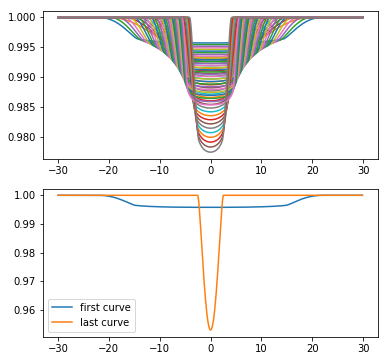

In [4]:
# A bunch of curves
f, axs = plt.subplots(2, figsize=(6,6))
for curveID in bcurves.colnames[3::5]:
    axs[0].plot(bcurves['times'], bcurves[curveID])
axs[1].plot(bcurves['times'], bcurves[bcurves.colnames[1]], label='first curve')
axs[1].plot(bcurves['times'], bcurves[bcurves.colnames[-1]], label='last curve')
plt.legend()

Reading TESS from /home/cjtu/projects/tess_batman/sampleData/sample_Sector0, s:2, e:3...
Reading Batman transit curves...
batmanCurves_test.csv
Starting convolutions...
Convolved 290 curves in 0.617 s
===START TCONVOLVE===
Reading TESS from sample_Sector0, s:2, e:3...
Found 1 TESS files to process
Reading Batman transit curves...
batmanCurves_test.csv
Found 290 Batman curves
Starting TESS file: HD_219666_b.fits
Starting convolutions...
Convolved 290 curves in 0.558 s
Convolved 1/1 tess files with 290 curves in 0.648 s
===END TCONVOLVE===
===START TCONVOLVE===
Reading TESS from sample_Sector0, s:0, e:9...
Found 9 TESS files to process
Reading Batman transit curves...
batmanCurves_test.csv
Found 290 Batman curves
Starting TESS file: HD_1397_b.fits
Starting convolutions...
Convolved 290 curves in 0.548 s
Starting TESS file: HD_202772_A_b.fits
Starting convolutions...
Convolved 290 curves in 0.644 s
Starting TESS file: HD_219666_b.fits
Starting convolutions...
Convolved 290 curves in 0.744

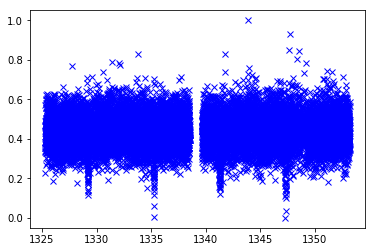

In [5]:
# pt = "/home/ctaiudovicic/projects/tess_batman/data/TESS/"
pt = "/home/cjtu/projects/tess_batman/sampleData/"
tstart = 2
tend = tstart+1
tess_names = read_tess(pt, pt+"sample_Sector0", tstart, tend)
times, curve_names, batmanCurves = read_batman(pb, suffix)
tess_time, tess_flux = open_tess_fits(tess_names[0], norm=True)
curves, times, convs = convolve(tess_time, tess_flux, batmanCurves, curve_names, num_keep=len(curve_names))

# candidates for tstart to tend
candidates = tbconvolve(pt, pb, suffix, 0, tstart, tend, pb, num_keep = -1, norm_tess=True, write=False)
# do all candidates and write to file
_ = tbconvolve(pt, pb, suffix, 0, 0, 9, pb, num_keep = -1, norm_tess=True, write=True)

plt.plot(tess_time, tess_flux, 'bx')

61 76


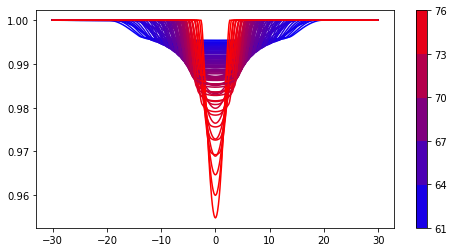

In [6]:
import matplotlib.colors as c
start = 10
step = 71

fig = plt.figure(figsize=(8, 4))
cm = c.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
# make colorbar
cmin = int(100*np.nanmin(candidates['correlation']))
cmax = int(100*np.nanmax(candidates['correlation']))
print(cmin, cmax)
if (cmax-cmin > 5):
    step = (cmax-cmin)//5
    if step < 1:
        step = 1
    Z = [[0,0],[0,0]]
    levels = range(cmin,cmax+step,step)
    CS3 = plt.contourf(Z, levels, cmap=cm)
    plt.clf()

    for i, curve in enumerate(bcurves.colnames[start::step]):#, len(candidates)):
        row = candidates[candidates['curveID'] == curve]
        r = (100*float(row['correlation'])-cmin)/(cmax-cmin)
        if r > 1:
            r = 1
        plt.plot(bcurves['times'], bcurves[curve], color=(r, 0, 1-r))
    plt.colorbar(CS3)

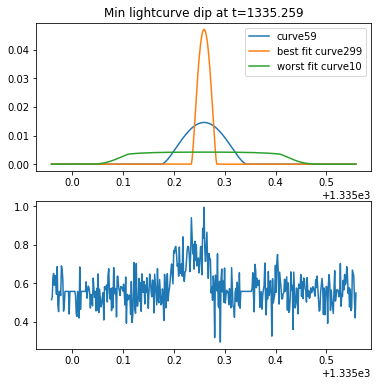

In [7]:
best = candidates[np.argmax(candidates['correlation'])]
worst = candidates[np.argmin(candidates['correlation'])]

# Search for dip
ind = np.argmin(tess_flux[:15700])
size = len(bcurves['times'])//2
s = ind-size
e = ind+size
mid = (e+s)//2

# Plot lightcurve, best and worst fits
f, axs = plt.subplots(2, figsize=(6,6))

testcurve = 'curve59'
axs[0].plot(tess_time[s:e], 1-bcurves[testcurve], label=testcurve)

axs[0].plot(tess_time[s:e], 1-bcurves[best['curveID']], label='best fit '+best['curveID'])
axs[0].plot(tess_time[s:e], 1-bcurves[worst['curveID']], label='worst fit '+worst['curveID'])
axs[1].plot(tess_time[s:e], 1-tess_flux[s:e])


axs[0].set_title("Min lightcurve dip at t={:.3f}".format(tess_time[ind]))
axs[0].legend()

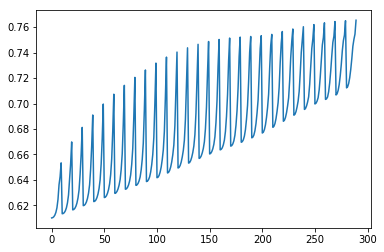

In [8]:
# max convolutions of each curve
plt.plot(convs)

curve10 1347.3552833404792 0.6101873906319727
curve60 1347.32195011349 0.6261611577294044
curve110 1347.3275056511675 0.6417567302334123
curve160 1347.3441722651332 0.6603905779714133
curve210 1347.326116766515 0.6768421449305478
curve260 1347.32195011349 0.6996703787753749
curve299 1335.2496901983852 0.7653937129226922


Text(0.5, 1.0, 'Light curve: HD_219666_b.fits')

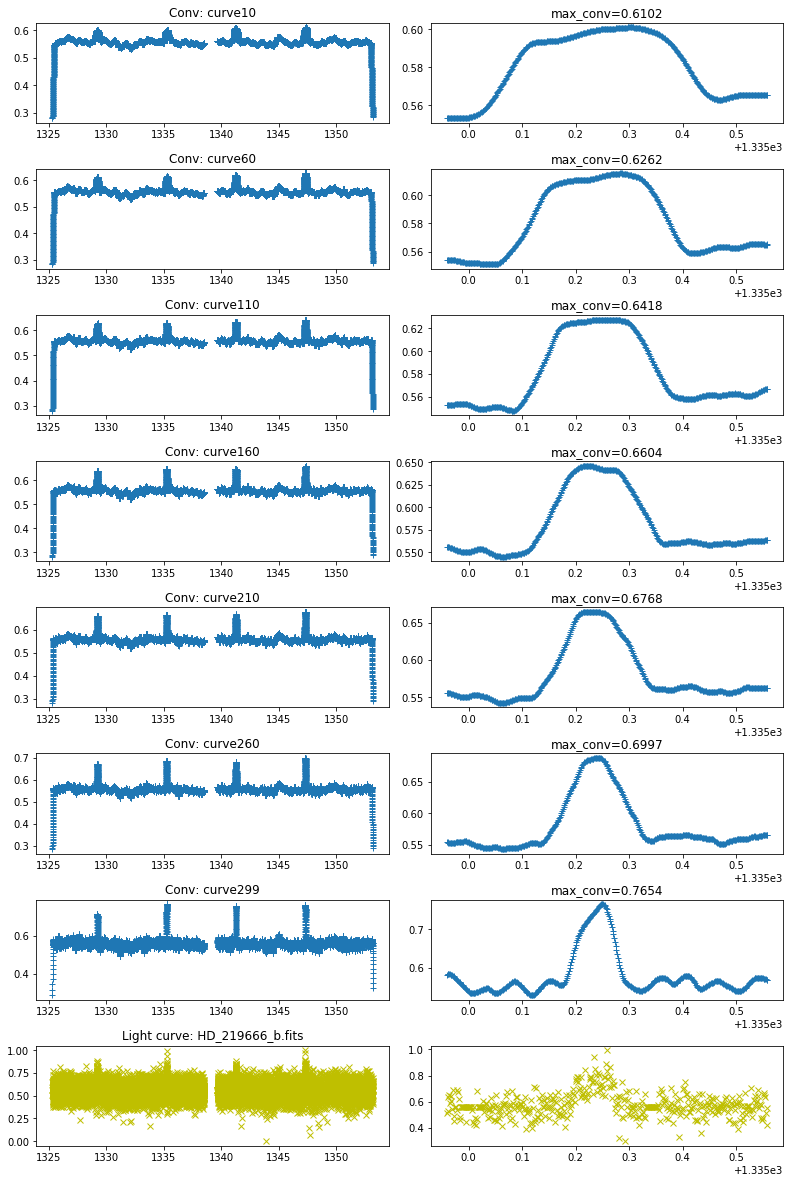

In [9]:
# manual convolve and plots
from scipy.signal import fftconvolve
plot = True


cnames = np.append(curve_names[0::50], best['curveID'])
nplots = len(cnames)+1
fig, axs = plt.subplots(nplots,2, figsize=(11, nplots*2))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.5)
for i, curvename in enumerate(cnames):
    batman_curve = batmanCurves[curvename]
    conv = np.abs(fftconvolve(1-tess_flux, (1-batman_curve), 'same'))
    ind_max = np.argmax(conv)
    conv_max = conv[ind_max]
    
    print(curvename, tess_time[ind_max], conv_max)
    axs[i,0].plot(tess_time, conv, '+')
    axs[i,1].plot(tess_time[s:e], conv[s:e], '+')
    axs[i,0].set_title("Conv: {}".format(curvename))
    axs[i,1].set_title("max_conv={:.4f}".format(conv_max))

     
axs[-1,0].plot(tess_time, 1-tess_flux, 'yx')
axs[-1,1].plot(tess_time[s:e], 1-tess_flux[s:e], 'yx')
axs[-1,0].set_title("Light curve: {}".format(tess_names[0].split("/")[-1]))


In [11]:
params_file = "batmanParams_test.csv"
candidates_file = "candidates_sector0_s0_e8.csv"
make_table(pt, params_file, candidates_file)

Opened file  /home/cjtu/projects/tess_batman/sampleData/sample_Sector0/HD_1397_b.fits


/mnt/c/Users/cjtai/projects/tess_batman/code/Science/generalized_chisquared.py:82: RuntimeWarning: invalid value encountered in greater
  outcounts = np.nan_to_num(pdcsap_fluxes[pdcsap_fluxes > np.nanmean(pdcsap_fluxes)])


Opened file  /home/cjtu/projects/tess_batman/sampleData/sample_Sector0/HD_202772_A_b.fits
Opened file  /home/cjtu/projects/tess_batman/sampleData/sample_Sector0/HD_219666_b.fits
Opened file  /home/cjtu/projects/tess_batman/sampleData/sample_Sector0/LHS_3844_b.fits
Opened file  /home/cjtu/projects/tess_batman/sampleData/sample_Sector0/pi_Men_c.fits
Opened file  /home/cjtu/projects/tess_batman/sampleData/sample_Sector0/tess2018263035959-s0003-0000000003836541-0123-s_lc.fits
Opened file  /home/cjtu/projects/tess_batman/sampleData/sample_Sector0/tess2018263035959-s0003-0000000003957254-0123-s_lc.fits
Opened file  /home/cjtu/projects/tess_batman/sampleData/sample_Sector0/tess2018349182459-s0006-0000000200319843-0126-s_lc.fits


/home/cjtu/anaconda3/envs/astro/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/cjtu/anaconda3/envs/astro/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Opened file  /home/cjtu/projects/tess_batman/sampleData/sample_Sector0/tess2018349182459-s0006-0000000404768604-0126-s_lc.fits
Wrote table chisquared_values.csv in 20.3138165473938 s


In [12]:
import pandas as pd
chisq_file = "chisquared_values.csv"
chisq = pd.read_csv(chisq_file)

In [13]:
chisq.sort_values('reducedChiSq').head(20)

,sector,tessFile,curveID,tcorr,correlation,rp,i,width,u,ld,t0,e,w,reducedChiSq
2252,sample_Sector0,tess2018349182459-s0006-0000000200319843-0126-...,curve232,1468.340905,0.757499,0.1,84.849881,0.001623,0.1 0.3,quadratic,0.0,0.0,0.0,47.068975
2221,sample_Sector0,tess2018349182459-s0006-0000000200319843-0126-...,curve201,1468.350627,0.754330,0.1,87.095249,0.001163,0.1 0.3,quadratic,0.0,0.0,0.0,47.081978
2296,sample_Sector0,tess2018349182459-s0006-0000000200319843-0126-...,curve276,1468.321461,0.765975,0.1,76.799962,0.002532,0.1 0.3,quadratic,0.0,0.0,0.0,47.082247
2076,sample_Sector0,tess2018349182459-s0006-0000000200319843-0126-...,curve56,1468.400627,0.743369,0.1,55.303642,0.000219,0.1 0.3,quadratic,0.0,0.0,0.0,47.086123
2256,sample_Sector0,tess2018349182459-s0006-0000000200319843-0126-...,curve236,1468.328405,0.762372,0.1,74.549643,0.001623,0.1 0.3,quadratic,0.0,0.0,0.0,47.095962
2044,sample_Sector0,tess2018349182459-s0006-0000000200319843-0126-...,curve24,1468.452015,0.739122,0.1,61.568453,0.000157,0.1 0.3,quadratic,0.0,0.0,0.0,47.096586
2212,sample_Sector0,tess2018349182459-s0006-0000000200319843-0126-...,curve192,1468.353405,0.753432,0.1,83.948823,0.001040,0.1 0.3,quadratic,0.0,0.0,0.0,47.100902
2278,sample_Sector0,tess2018349182459-s0006-0000000200319843-0126-...,curve258,1468.311739,0.777199,0.1,70.966134,0.002027,0.1 0.3,quadratic,0.0,0.0,0.0,47.109623
2111,sample_Sector0,tess2018349182459-s0006-0000000200319843-0126-...,curve91,1468.397849,0.745457,0.1,85.312644,0.000342,0.1 0.3,quadratic,0.0,0.0,0.0,47.124661
2261,sample_Sector0,tess2018349182459-s0006-0000000200319843-0126-...,curve241,1468.339516,0.757934,0.1,87.525053,0.001814,0.1 0.3,quadratic,0.0,0.0,0.0,47.126416
